# Map 3D data

We will map using noisy data, where the "truth" function is 
$$
f(x) = sin(kx+ly - \omega t)
$$

We purposefully added a time dimension, since we are trying to map Argo data along the time axis too. 

In [1]:
import george as grg
import numpy as np
import matplotlib.pyplot as plt
import xarray as xr

In [2]:
np.random.seed(1234);
xr.set_options(display_style='html');

In [3]:
def fake_3d_data(n_samples, rangex=1, rangey=1, ranget=1, k=2*np.pi, l=2*np.pi, om=2*np.pi, eta=0.1):
    
    # generate a vector that has n_samples rows and 3 rows corresponding to x,y,t
    xND = np.random.rand(n_samples, 3)
    
    # Since the above vector was generated using uniform distributions that vary between 0,1
    # we now rescale them to dimensionalize them (ex. if we want x to vary between 0-10, we set rangex=10)
    x = xND
    x[:,0] = rangex*x[:,0]
    x[:,1] = rangey*x[:,1]
    x[:,2] = ranget*x[:,2]
        
    # convert to xarray since we will be getting the argo data in this form
    x = xr.DataArray(x,  dims=["samplenum", "coordinate"], coords=[range(n_samples), ['x','y','t']])
    
    # generate some random uncorrelated noise with a gaussian distribution
    # This will be added to each sample, and corresponds to the observational noise 
    yerr = eta * np.random.randn(n_samples)
    
    y = np.sin(k*x.sel(coordinate='x') + l*x.sel(coordinate='y') - om*x.sel(coordinate='t')) + yerr
    
    return x, y

In [10]:
# Generate a fake data set at some random sample points.
eta = 0.1
[x,y] = fake_3d_data(1200, 10,10,2, 1, 1.5 , 2*np.pi, eta)

Text(0, 0.5, 'y')

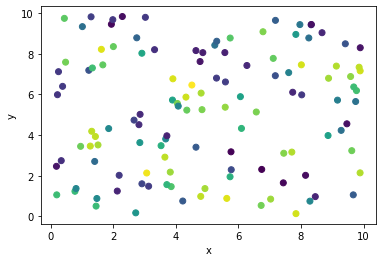

In [11]:
# Pick a little bit of data around some time to plot 
# The interpolation effort will be done by GP later, so no point interpolating now.
y_sel = y.where(np.logical_and(x.sel(coordinate='t')<1 , x.sel(coordinate='t')>0.8), drop='true')
x_sel = x.where(np.logical_and(x.sel(coordinate='t')<1 , x.sel(coordinate='t')>0.8), drop='true')

plt.scatter(x_sel.sel(coordinate='x'), x_sel.sel(coordinate='y'), c=y_sel)
plt.xlabel('x')
plt.ylabel('y')
# notice that the data looks sinusoidal

Text(0, 0.5, 't')

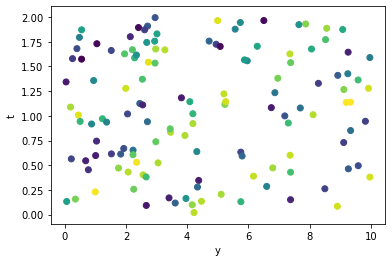

In [12]:
# Pick a little bit of data around some x,y to plot 
# The interpolation effort will be done by GP later, so no point interpolating now.
y_sel = y.where(np.logical_and(x.sel(coordinate='x')<1.5 , x.sel(coordinate='x')>0.5), drop='true')
x_sel = x.where(np.logical_and(x.sel(coordinate='x')<1.5 , x.sel(coordinate='x')>0.5), drop='true')

plt.scatter(x_sel.sel(coordinate='y'), x_sel.sel(coordinate='t'), c=y_sel)
plt.xlabel('y')
plt.ylabel('t')
# notice that the data is a wave that propogates towards larger y as time progresses

In [13]:
# Now lets choose some kernel for this data.
# Since we are trying to predict at scales that are much smaller than sinusoidal wave,
# using a simple smooth kernel should suffice.
# The excess of data points will ensure the periodicity 

# Further we might anticipate the length scales in the x,y,t direction might be different
# like was expected in Kuusela and Stein 2018
# So we design a kernel that is multiplication of the 3. 

#kernel = grg.kernels.ConstantKernel(0.1, ndim=3) * \
#        grg.kernels.ExpSquaredKernel([0.5, 0.5, 1], ndim=3)

kernel = 0.5*grg.kernels.ExpSquaredKernel([.5, .5, 0.5], ndim=3)

In [14]:
print(kernel.get_parameter_names())
print(kernel.get_parameter_vector())

# Note that in this case M is a 3X3 tensor, but since we are using the axis-aligned form
# only the elements along the diagonal (M_i_i) are non-zero.

('k1:log_constant', 'k2:metric:log_M_0_0', 'k2:metric:log_M_1_1', 'k2:metric:log_M_2_2')
[-1.79175947 -0.69314718 -0.69314718 -0.69314718]


In [15]:
test_x = np.array(np.meshgrid(np.linspace(0,1,20), 
                       np.linspace(0,1,10),
                       np.linspace(0,2,10)))

In [16]:
# Now lets start the GP process. 
# First we tell the GP what the kernel choice is. 
gp = grg.GP(kernel)
# At this point the GP knows nothing, except that the mean=0 and what the kernel is. 

In [25]:
# We can use this to draw some random samples from this multi-dimensional Gaussian 
# at a bunch of test points.
# We select them to be uniformly arranged, but that does not need to be the case.

test_pts = np.array(np.meshgrid(np.linspace(0,10,30), 
                       np.linspace(0,10,10),
                       np.linspace(0,2,10))).reshape(3,-1).T


In [26]:
test_pts = xr.DataArray(test_pts,  dims=["test_pt_num","coordinate"], 
                        coords=[range(test_pts.shape[0]), ['x','y','t']] ) 

In [27]:
# Before we proceed to do any fitting, we can see that with the initial parameters 
# we have defined a family of infinite functions. These can be sampled at the test points

samples = gp.sample(test_pts, 4)
# this step can be done properly using apply_ufunc
# These samples have been drawn from the prior (the distribution specified by us, where no knowledge of the input data is present).

In [28]:
samples = xr.DataArray(samples,  dims=["func_sample_num", "test_pt_num"])

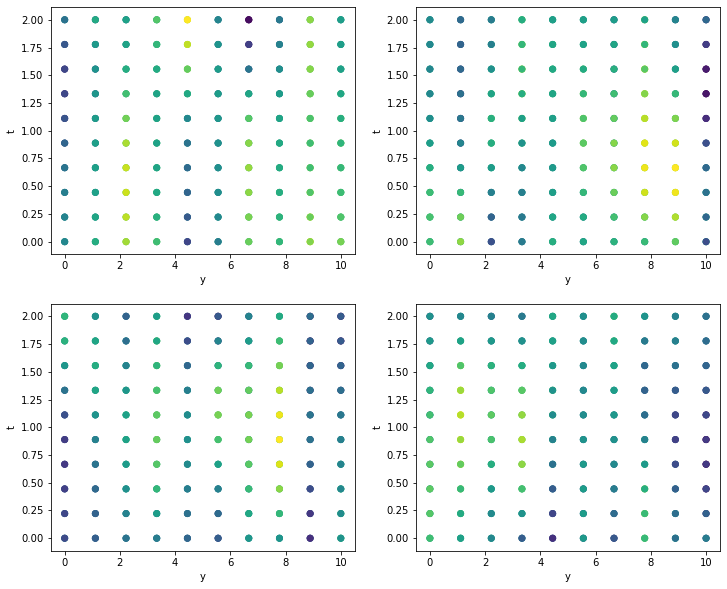

In [29]:
plt.figure(figsize=(12,10))
for i in range(4):
    
    plt.subplot(2,2,i+1)
    y_sel = samples.sel(func_sample_num=i).where(np.logical_and(test_pts.sel(coordinate='x')<2 ,
                                   test_pts.sel(coordinate='x')>0.8), drop='true')
    x_sel = test_pts.where(np.logical_and(test_pts.sel(coordinate='x')<2 , 
                                   test_pts.sel(coordinate='x')>0.8), drop='true')

    plt.scatter(x_sel.sel(coordinate='y'), x_sel.sel(coordinate='t'), c=y_sel)
    plt.xlabel('y')
    plt.ylabel('t')
    
# Interesting shapes of functions have been samples. 
# Note that based on our prior choice of the kernel parameters, the functions
# are very smooth. Our "truth" function is much more wavy, so presumably when fitting
# the parameters the optimized length scales would be shrunk.

In [30]:
# Now let us set up the GP. 
# This is done by precomputing some covariance matrices, corresponding
# to the input data, and factorizing it
gp.compute(x, eta) 
# here we just set the random error to be the same as what we prescribed
# presumably, we can optimize for it (?)

In [31]:
pred, pred_var = gp.predict(y, test_pts, return_var=True)
# Here the parameters introduced initially are used. No optimization is done. 
# This is the posterior distribution, where the hyper parameters were manually chosen. 
pred = xr.DataArray(pred,  dims={"test_pt_num"})
pred_var = xr.DataArray(pred_var,  dims={"test_pt_num"})

In [ ]:
# Write function to estimate the truth at more than the input points, using the input that
# was used to create the fake data.
# truth = 

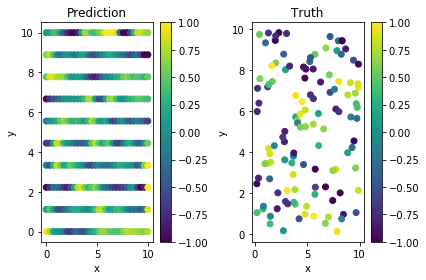

In [33]:
plt.subplot(121)
y_sel = pred.where(np.logical_and(test_pts.sel(coordinate='t')<1 ,
                                   test_pts.sel(coordinate='t')>0.8), drop='true')
x_sel = test_pts.where(np.logical_and(test_pts.sel(coordinate='t')<1 , 
                                   test_pts.sel(coordinate='t')>0.8), drop='true')

plt.scatter(x_sel.sel(coordinate='x'), x_sel.sel(coordinate='y'), c=y_sel, vmin=-1, vmax=1)
plt.xlabel('x')
plt.ylabel('y')
plt.colorbar()
plt.title('Prediction')

plt.subplot(122)
y_sel = y.where(np.logical_and(x.sel(coordinate='t')<1 , x.sel(coordinate='t')>0.8), drop='true')
x_sel = x.where(np.logical_and(x.sel(coordinate='t')<1 , x.sel(coordinate='t')>0.8), drop='true')

plt.scatter(x_sel.sel(coordinate='x'), x_sel.sel(coordinate='y'), c=y_sel, vmin=-1, vmax=1)
plt.xlabel('x')
plt.ylabel('y')
plt.colorbar()
plt.title('Truth')

plt.tight_layout()

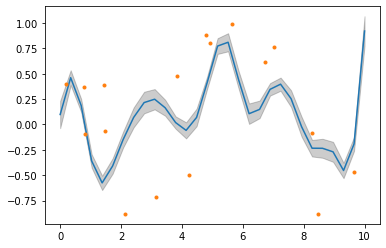

In [34]:
y_sel = pred.where(np.logical_and(test_pts.sel(coordinate='t')<1 ,
                                   test_pts.sel(coordinate='t')>0.8) & 
                   np.logical_and(test_pts.sel(coordinate='y')<1.5 ,
                                   test_pts.sel(coordinate='y')>0.5) 
                   , drop='true')

y_var = pred_var.where(np.logical_and(test_pts.sel(coordinate='t')<1 ,
                                   test_pts.sel(coordinate='t')>0.8) & 
                   np.logical_and(test_pts.sel(coordinate='y')<1.5 ,
                                   test_pts.sel(coordinate='y')>0.5) 
                   , drop='true')

x_sel = test_pts.where(np.logical_and(test_pts.sel(coordinate='t')<1 , 
                                   test_pts.sel(coordinate='t')>0.8) & 
                   np.logical_and(test_pts.sel(coordinate='y')<1.5 ,
                                   test_pts.sel(coordinate='y')>0.5) 
                       , drop='true')

x_sel_input = x.where(np.logical_and(x.sel(coordinate='t')<1 , 
                                   x.sel(coordinate='t')>0.8) & 
                   np.logical_and(x.sel(coordinate='y')<1.5 ,
                                   x.sel(coordinate='y')>0.5) 
                       , drop='true')

y_sel_input = y.where(np.logical_and(x.sel(coordinate='t')<1 ,
                                   x.sel(coordinate='t')>0.8) & 
                       np.logical_and(x.sel(coordinate='y')<1.5 ,
                                   x.sel(coordinate='y')>0.5) 
                   , drop='true')

plt.fill_between(x_sel.sel(coordinate='x'), y_sel - np.sqrt(y_var), y_sel + np.sqrt(y_var),
                color="k", alpha=0.2)
plt.plot(x_sel.sel(coordinate='x'), y_sel)
plt.plot(x_sel_input.sel(coordinate='x'), y_sel_input, '.')

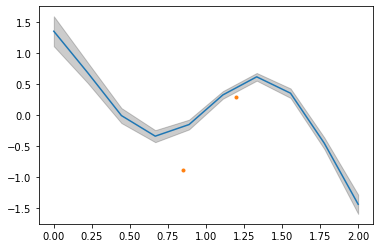

In [35]:
y_sel = pred.where(np.logical_and(test_pts.sel(coordinate='x')<2.2 ,
                                   test_pts.sel(coordinate='x')>1.9) & 
                   np.logical_and(test_pts.sel(coordinate='y')<1.5 ,
                                   test_pts.sel(coordinate='y')>0.5) 
                   , drop='true')

y_var = pred_var.where(np.logical_and(test_pts.sel(coordinate='x')<2.2 ,
                                   test_pts.sel(coordinate='x')>1.9) & 
                   np.logical_and(test_pts.sel(coordinate='y')<1.5 ,
                                   test_pts.sel(coordinate='y')>0.5) 
                   , drop='true')

x_sel = test_pts.where(np.logical_and(test_pts.sel(coordinate='x')<2.2 , 
                                   test_pts.sel(coordinate='x')>1.9) & 
                   np.logical_and(test_pts.sel(coordinate='y')<1.5 ,
                                   test_pts.sel(coordinate='y')>0.5) 
                       , drop='true')

x_sel_input = x.where(np.logical_and(x.sel(coordinate='x')<2.2, 
                                   x.sel(coordinate='x')>1.9) & 
                   np.logical_and(x.sel(coordinate='y')<1.5 ,
                                   x.sel(coordinate='y')>0.5) 
                       , drop='true')

y_sel_input = y.where(np.logical_and(x.sel(coordinate='x')<2.2 ,
                                   x.sel(coordinate='x')>1.9) & 
                       np.logical_and(x.sel(coordinate='y')<1.5 ,
                                   x.sel(coordinate='y')>0.5) 
                   , drop='true')

plt.fill_between(x_sel.sel(coordinate='t'), y_sel - np.sqrt(y_var), y_sel + np.sqrt(y_var),
                color="k", alpha=0.2)
plt.plot(x_sel.sel(coordinate='t'), y_sel)
plt.plot(x_sel_input.sel(coordinate='t'), y_sel_input, '.')

In [36]:
# Since we chose kernel parameters that were good guesses, we got decent fits.
# The functions look sort of like sinusoidals.
# Can we do better? 
# Interesting to note that the sinusoidal behavior came in because the input data had that structure,
# the kernal did not have any idea about periodicity. 

print("Initial ln-likelihood: {0:.2f}".format(gp.log_likelihood(y)))
# Does this not have to be less than 1? 

Initial ln-likelihood: -8295.06


In [37]:
# We use scipy's gradient descent minimizer to minimize. Since we want to maximize the likelihood, 
# minimizing the -log(likelihood) works too. This is what is known as maximum likelihood estimate. 
# There are other ways to do this, like the MCMC - which is an approach where the uncertainity
# in the "best" parameters is also expressed. 

from scipy.optimize import minimize

def neg_ln_like(p):
    gp.set_parameter_vector(p)
    return -gp.log_likelihood(y)

def grad_neg_ln_like(p):
    gp.set_parameter_vector(p)
    return -gp.grad_log_likelihood(y)

In [38]:
%time result = minimize(neg_ln_like, gp.get_parameter_vector(), jac=grad_neg_ln_like)
print(result)
# this is the minimized set of parameters
# This takes a long time. (how does the time for this scale?)

CPU times: user 12.5 s, sys: 388 ms, total: 12.9 s
Wall time: 7.94 s
      fun: 135.21515205745777
 hess_inv: array([[0.01777274, 0.00494454, 0.00506832, 0.00503723],
       [0.00494454, 0.00363482, 0.00108226, 0.00061331],
       [0.00506832, 0.00108226, 0.00320428, 0.00087731],
       [0.00503723, 0.00061331, 0.00087731, 0.00367922]])
      jac: array([-1.55966330e-07, -4.81399360e-06,  9.09245637e-06, -1.15170405e-06])
  message: 'Optimization terminated successfully.'
     nfev: 25
      nit: 20
     njev: 25
   status: 0
  success: True
        x: array([-0.47187503,  0.94328557,  0.17660156, -2.67876366])


In [39]:
# Let's set the parameters to be these new ones, derived from MLE
gp.set_parameter_vector(result.x)
print("\nFinal ln-likelihood: {0:.2f}".format(gp.log_likelihood(y)))
# note that this final likelihood is bigger than what we started with. This
# is good since we wanted to maximize. 



Final ln-likelihood: -135.22


In [40]:
pred_MLE, pred_var_MLE = gp.predict(y, test_pts, return_var=True)
# Here the parameters introduced initially are used. No optimization is done. 
# This is the posterior distribution, where the hyper parameters were manually chosen. 
pred_MLE = xr.DataArray(pred_MLE,  dims={"test_pt_num"})
pred_var_MLE = xr.DataArray(pred_var_MLE,  dims={"test_pt_num"})

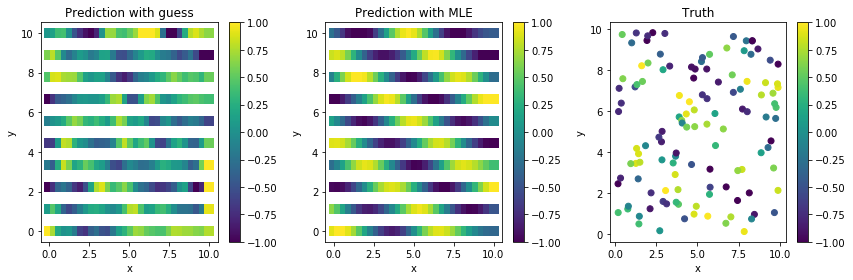

In [41]:
plt.figure(figsize=(12,4))
plt.subplot(131)
y_sel = pred.where(np.logical_and(test_pts.sel(coordinate='t')<1 ,
                                   test_pts.sel(coordinate='t')>0.8), drop='true')
x_sel = test_pts.where(np.logical_and(test_pts.sel(coordinate='t')<1 , 
                                   test_pts.sel(coordinate='t')>0.8), drop='true')

plt.scatter(x_sel.sel(coordinate='x'), x_sel.sel(coordinate='y'), c=y_sel, vmin=-1, vmax=1, s=100, marker="s", edgecolor="none",)
plt.xlabel('x')
plt.ylabel('y')
plt.colorbar()
plt.title('Prediction with guess')

plt.subplot(132)
y_sel = pred_MLE.where(np.logical_and(test_pts.sel(coordinate='t')<1 ,
                                   test_pts.sel(coordinate='t')>0.8), drop='true')
x_sel = test_pts.where(np.logical_and(test_pts.sel(coordinate='t')<1 , 
                                   test_pts.sel(coordinate='t')>0.8), drop='true')

plt.scatter(x_sel.sel(coordinate='x'), x_sel.sel(coordinate='y'), c=y_sel, vmin=-1, vmax=1, s=100, marker="s", edgecolor="none",)
plt.xlabel('x')
plt.ylabel('y')
plt.colorbar()
plt.title('Prediction with MLE')

plt.subplot(133)
y_sel = y.where(np.logical_and(x.sel(coordinate='t')<1 , x.sel(coordinate='t')>0.8), drop='true')
x_sel = x.where(np.logical_and(x.sel(coordinate='t')<1 , x.sel(coordinate='t')>0.8), drop='true')

plt.scatter(x_sel.sel(coordinate='x'), x_sel.sel(coordinate='y'), c=y_sel, vmin=-1, vmax=1)
plt.xlabel('x')
plt.ylabel('y')
plt.colorbar()
plt.title('Truth')

plt.tight_layout()

# Pretty damn good, huh?

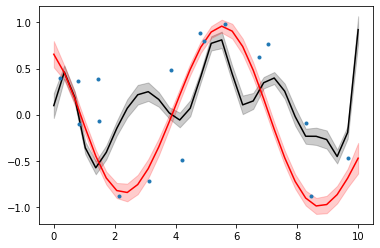

In [42]:
y_sel = pred.where(np.logical_and(test_pts.sel(coordinate='t')<1 ,
                                   test_pts.sel(coordinate='t')>0.8) & 
                   np.logical_and(test_pts.sel(coordinate='y')<1.5 ,
                                   test_pts.sel(coordinate='y')>0.5) 
                   , drop='true')

y_var = pred_var.where(np.logical_and(test_pts.sel(coordinate='t')<1 ,
                                   test_pts.sel(coordinate='t')>0.8) & 
                   np.logical_and(test_pts.sel(coordinate='y')<1.5 ,
                                   test_pts.sel(coordinate='y')>0.5) 
                   , drop='true')

y_sel_MLE = pred_MLE.where(np.logical_and(test_pts.sel(coordinate='t')<1 ,
                                   test_pts.sel(coordinate='t')>0.8) & 
                   np.logical_and(test_pts.sel(coordinate='y')<1.5 ,
                                   test_pts.sel(coordinate='y')>0.5) 
                   , drop='true')

y_var_MLE = pred_var_MLE.where(np.logical_and(test_pts.sel(coordinate='t')<1 ,
                                   test_pts.sel(coordinate='t')>0.8) & 
                   np.logical_and(test_pts.sel(coordinate='y')<1.5 ,
                                   test_pts.sel(coordinate='y')>0.5) 
                   , drop='true')

x_sel = test_pts.where(np.logical_and(test_pts.sel(coordinate='t')<1 , 
                                   test_pts.sel(coordinate='t')>0.8) & 
                   np.logical_and(test_pts.sel(coordinate='y')<1.5 ,
                                   test_pts.sel(coordinate='y')>0.5) 
                       , drop='true')

x_sel_input = x.where(np.logical_and(x.sel(coordinate='t')<1 , 
                                   x.sel(coordinate='t')>0.8) & 
                   np.logical_and(x.sel(coordinate='y')<1.5 ,
                                   x.sel(coordinate='y')>0.5) 
                       , drop='true')

y_sel_input = y.where(np.logical_and(x.sel(coordinate='t')<1 ,
                                   x.sel(coordinate='t')>0.8) & 
                       np.logical_and(x.sel(coordinate='y')<1.5 ,
                                   x.sel(coordinate='y')>0.5) 
                   , drop='true')

plt.fill_between(x_sel.sel(coordinate='x'), y_sel - np.sqrt(y_var), y_sel + np.sqrt(y_var),
                color="k", alpha=0.2)
plt.plot(x_sel.sel(coordinate='x'), y_sel, color='k')

plt.fill_between(x_sel.sel(coordinate='x'), y_sel_MLE - np.sqrt(y_var_MLE), y_sel_MLE + np.sqrt(y_var_MLE),
                color="r", alpha=0.2)
plt.plot(x_sel.sel(coordinate='x'), y_sel_MLE, color='r')

plt.plot(x_sel_input.sel(coordinate='x'), y_sel_input, '.')

# Pretty damn good, huh?

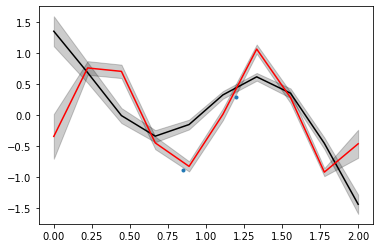

In [43]:
y_sel = pred.where(np.logical_and(test_pts.sel(coordinate='x')<2.2 ,
                                   test_pts.sel(coordinate='x')>1.9) & 
                   np.logical_and(test_pts.sel(coordinate='y')<1.5 ,
                                   test_pts.sel(coordinate='y')>0.5) 
                   , drop='true')

y_var = pred_var.where(np.logical_and(test_pts.sel(coordinate='x')<2.2 ,
                                   test_pts.sel(coordinate='x')>1.9) & 
                   np.logical_and(test_pts.sel(coordinate='y')<1.5 ,
                                   test_pts.sel(coordinate='y')>0.5) 
                   , drop='true')

y_sel_MLE = pred_MLE.where(np.logical_and(test_pts.sel(coordinate='x')<2.2 ,
                                   test_pts.sel(coordinate='x')>1.9) & 
                   np.logical_and(test_pts.sel(coordinate='y')<1.5 ,
                                   test_pts.sel(coordinate='y')>0.5) 
                   , drop='true')

y_var_MLE = pred_var_MLE.where(np.logical_and(test_pts.sel(coordinate='x')<2.2 ,
                                   test_pts.sel(coordinate='x')>1.9) & 
                   np.logical_and(test_pts.sel(coordinate='y')<1.5 ,
                                   test_pts.sel(coordinate='y')>0.5) 
                   , drop='true')

x_sel = test_pts.where(np.logical_and(test_pts.sel(coordinate='x')<2.2 , 
                                   test_pts.sel(coordinate='x')>1.9) & 
                   np.logical_and(test_pts.sel(coordinate='y')<1.5 ,
                                   test_pts.sel(coordinate='y')>0.5) 
                       , drop='true')

x_sel_input = x.where(np.logical_and(x.sel(coordinate='x')<2.2, 
                                   x.sel(coordinate='x')>1.9) & 
                   np.logical_and(x.sel(coordinate='y')<1.5 ,
                                   x.sel(coordinate='y')>0.5) 
                       , drop='true')

y_sel_input = y.where(np.logical_and(x.sel(coordinate='x')<2.2 ,
                                   x.sel(coordinate='x')>1.9) & 
                       np.logical_and(x.sel(coordinate='y')<1.5 ,
                                   x.sel(coordinate='y')>0.5) 
                   , drop='true')

plt.fill_between(x_sel.sel(coordinate='t'), y_sel - np.sqrt(y_var), y_sel + np.sqrt(y_var),
                color="k", alpha=0.2)
plt.plot(x_sel.sel(coordinate='t'), y_sel, color='k')

plt.fill_between(x_sel.sel(coordinate='t'), y_sel_MLE - np.sqrt(y_var_MLE), y_sel_MLE + np.sqrt(y_var_MLE),
                color="k", alpha=0.2)
plt.plot(x_sel.sel(coordinate='t'), y_sel_MLE, color='r')

plt.plot(x_sel_input.sel(coordinate='t'), y_sel_input, '.')

# Pretty damn good, huh?

In [47]:
print(gp.parameter_names)
print(np.exp(gp.parameter_vector))
# Length scales associated with the x,y directions are 2.5, 1.2 
# this is good since we chose a lower mode structure in x than y.
# Also the time scale is 0.06, which also great since omega even bigger than k,l. 
# This is good, and implies that there is some physical value in the parameters that
# resulted. 

('mean:value', 'white_noise:value', 'kernel:k1:log_constant', 'kernel:k2:metric:log_M_0_0', 'kernel:k2:metric:log_M_1_1', 'kernel:k2:metric:log_M_2_2')
[1.00000000e+00 1.25000000e-12 6.23831467e-01 2.56840624e+00
 1.19315560e+00 6.86479738e-02]


In [ ]:
# Here we got pretty far from using the exponential kernel. This is because 
# the origional function is very smooth - the power spectrum is only delta function at k,l, omega. 
# However, most natural data will not be like this - it generally has some sort of piecewise powerspectrum. If anything,
# this kernal might have made the function rougher than what we entered in. 

## Now towards Argo data

In [41]:
## Argo data 
ds = xr.open_dataset('anom_data.nc')
num_samples = len(ds.r)
Xinput = np.zeros((num_samples, 3)) # 3 coordinates for lon, lat, time
Xinput[:,0] = ds.Lon.values
Xinput[:,1] = ds.Lat.values
Xinput[:,2] = ds.Time.values
Yinput = ds.Data.isel(c=0).values

Xinput = xr.DataArray(Xinput, dims=["samplenum", "coordinate"], coords=[range(num_samples), ['lon','lat','time']]).rename('Input_coordinates')
Yinput = xr.DataArray(Yinput, dims=["samplenum"]).rename('Anomaly_data')

Argo_input = xr.merge([Xinput, Yinput])

Argo_input

<xarray.Dataset>
Dimensions:            (coordinate: 3, samplenum: 4089)
Coordinates:
  * samplenum          (samplenum) int64 0 1 2 3 4 ... 4084 4085 4086 4087 4088
  * coordinate         (coordinate) <U4 'lon' 'lat' 'time'
Data variables:
    Input_coordinates  (samplenum, coordinate) float64 -144.4 ... 1.504e+18
    Anomaly_data       (samplenum) float64 -0.2994 -0.2045 ... -0.3255 -0.5773

In [208]:
ds.Data.where(np.isnan(ds.Data), drop=True)

<xarray.DataArray 'Data' (c: 0, r: 0)>
array([], shape=(0, 0), dtype=float64)
Dimensions without coordinates: c, r

In [209]:
lat = ds.Lat.values[0]
lon = ds.Lon.values[0]
tme = ds.Time.values[0]
dta  = ds.Data.values[0]

In [ ]:
import pandas as pd
idx = pd.MultiIndex.from_arrays(arrays=[lat,lon,tme], names=['Lat','Lon','Time'])
s = pd.Series(data=dta, index=idx)
da = xr.DataArray.from_series(s)

In [ ]:
da

Below is code from Isabelle, from where I picked up on wednesday afternoon.

# Map 2D data

This notebook will have the algorithm for how to map 2D data using the (george package)[https://george.readthedocs.io/en/latest/]. 

>An example of doing this is present in https://gist.github.com/shoyer/80aa06f5ad44aacd9187 (using an older version of george).

The main steps are: 

First things first  
https://nbviewer.jupyter.org/github/adamian/adamian.github.io/blob/master/talks/Brown2016.ipynb

A Gaussian process (GP) is a collection of random variables, any finite number of which have a joint Gaussian distribution.

Equivalently, a GP can be seen as a stochastic process which corresponds to an infinite dimensional Gaussian distribution.



 *Using GP regression to grid ungridded data*

In [48]:
# Load appropriate modules
import george
from george import kernels
from george.kernels import Matern32Kernel

import numpy as np
import matplotlib.pyplot as plt
from itertools import product

In [8]:
# Relevant definitions

In [9]:
# Optimisation routines

# From first example

from scipy.optimize import minimize


def neg_ln_like(p):
    gp.set_parameter_vector(p)
    return -gp.log_likelihood(y)


def grad_neg_ln_like(p):
    gp.set_parameter_vector(p)
    return -gp.grad_log_likelihood(y)

In [10]:
# on hyperparameterisation

import scipy.optimize as op

# Define the objective function (negative log-likelihood in this case).
def nll(p):
    gp.set_parameter_vector(p)
    ll = gp.log_likelihood(y, quiet=True)
    return -ll if np.isfinite(ll) else 1e25


# And the gradient of the objective function.
def grad_nll(p):
    gp.set_parameter_vector(p)
    return -gp.grad_log_likelihood(y, quiet=True)

In [12]:
def fake_2d_data(n_samples):
    x = np.sqrt(n_samples / 10.0) * np.random.RandomState(12356).rand(n_samples, 2)
    yerr = 0.2 * np.ones_like(x[:, 0])
    y = np.sin(x[:, 0] + x[:, 1]) + yerr * np.random.randn(len(x))
    return x, y

thinking about the time axis 

K&T 2018 - Sum of three Matern / Exp functions describing the covariance of the variable 
1. with reference to lat
2. with reference to lon
3. with reference to time




# following shoyer 

1 Generate 2D data (e.g. could be a 2D function like : sin (x+y) + error ),with some prescribed parameters.
  -- Alternatively, we could just use a test data set that I have for this step that has data that 
  -- is a function of (lat, lon, time), like the Argo data will be.

https://gist.github.com/shoyer/80aa06f5ad44aacd9187

## Using Matern32

Adopted by Park et al 2020  
With the advantage of the results being differentiable


In [85]:
n_samples = 1000
x, y = fake_2d_data(n_samples)

test_pts = (
    np.array(
        np.meshgrid(
            np.linspace(0, np.sqrt(n_samples / 10.0), num=50),
            np.linspace(0, np.sqrt(n_samples / 10.0), num=50),
        )
    )
    .reshape(2, -1)
    .T
)

%time mu, cov = gp.predict(y, test_pts)

kernel = 0.5 * Matern32Kernel(
    metric=0.5, ndim=2
)  # Metric is the length scale (defined in sci-kit learn) of the kernel.
# If a float, an isotropic kernel is used.
# If an array, an anisotropic kernel is used where
# each dimension of l defines the length-scale of the
# respective feature dimension.
# Instead of constant kernal add variance of GP?

kernel = np.var(y) * Matern32Kernel(metric=0.5, ndim=2)

# This test data is isotropic, but the ocean is anisotropic

# kernel = 0.5 * Matern32Kernel(metric=[[5,4],[1,5]], ndim=2)  # Example using varying length scales, this is the generarl case
# kernel = kernels.ExpSquaredKernel(metric=[13.0, 0.1],ndim=2)  # Variances in different directions (axis-aligned option)
# (tested here to see how this changes/distorts the estimated field - the optimisation function fixes this! )
# There is a third option, general case, which allows for arbitrary covariances between dimensions (e.g metric = [[12.0, 0.1],[0.1,13.0]])
# Smaller length scales result in more complex functions

print("Parameter vector", kernel.get_parameter_vector())
gp = george.GP(kernel, white_noise=np.log(0.19 ** 2), fit_white_noise=True)
gp.compute(x)

mu, cov = gp.predict(
    y, test_pts
)  # this is where George performs maximum likelihood estimation

CPU times: user 902 ms, sys: 16.4 ms, total: 918 ms
Wall time: 235 ms
Parameter vector [-1.29276715 -0.69314718]


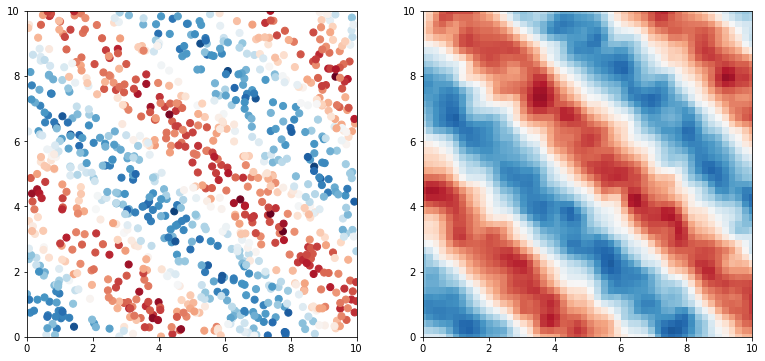

In [86]:
f, axes = plt.subplots(1, 2, figsize=(13, 6))

style = dict(cmap="RdBu", vmin=-1.5, vmax=1.5)
axes[0].scatter(x[:, 0], x[:, 1], c=y, s=50, **style)
axes[1].scatter(
    test_pts[:, 0], test_pts[:, 1], c=mu, s=50, marker="s", edgecolor="none", **style
)


for ax in axes:
    ax.set_xlim(0, np.sqrt(n_samples / 10))
    ax.set_ylim(0, np.sqrt(n_samples / 10))

Optimize

In [76]:
print("Initial ln-likelihood: {0:.2f}".format(gp.log_likelihood(y)))

Initial ln-likelihood: -1000.66


In [77]:
# You need to compute the GP once before starting the optimization.
gp.compute(x)

# Print the initial ln-likelihood.
print(gp.log_likelihood(y))

# Run the optimization routine.
p0 = gp.get_parameter_vector()
results = op.minimize(nll, p0, jac=grad_nll, method="L-BFGS-B")

# Update the kernel and print the final log-likelihood.
gp.set_parameter_vector(results.x)
print(gp.log_likelihood(y))

-1000.6570292478991
8.484262064866812


In [78]:
result = minimize(neg_ln_like, gp.get_parameter_vector(), jac=grad_neg_ln_like)
print(result)

gp.set_parameter_vector(result.x)
print("\nFinal ln-likelihood: {0:.2f}".format(gp.log_likelihood(y)))

      fun: -8.484262064866812
 hess_inv: array([[1, 0, 0],
       [0, 1, 0],
       [0, 0, 1]])
      jac: array([3.05479798e-07, 4.21673256e-07, 6.93393687e-07])
  message: 'Optimization terminated successfully.'
     nfev: 1
      nit: 0
     njev: 1
   status: 0
  success: True
        x: array([-3.1313911 ,  0.97408999,  1.00467499])

Final ln-likelihood: 8.48


In [79]:
mu, cov = gp.predict(y, test_pts)

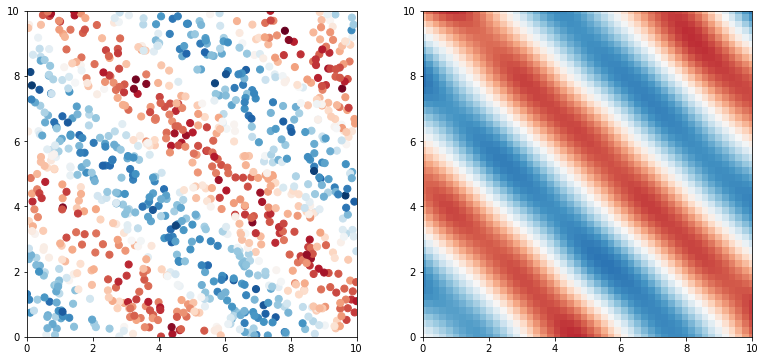

In [80]:
f, axes = plt.subplots(1, 2, figsize=(13, 6))

style = dict(cmap="RdBu", vmin=-1.5, vmax=1.5)
axes[0].scatter(x[:, 0], x[:, 1], c=y, s=50, **style)
axes[1].scatter(
    test_pts[:, 0], test_pts[:, 1], c=mu, s=50, marker="s", edgecolor="none", **style
)


for ax in axes:
    ax.set_xlim(0, np.sqrt(n_samples / 10))
    ax.set_ylim(0, np.sqrt(n_samples / 10))

##  Exponential 
used by K&S 2018

In [385]:
test_pts = (
    np.array(
        np.meshgrid(
            np.linspace(0, np.sqrt(n_samples / 10.0), num=50),
            np.linspace(0, np.sqrt(n_samples / 10.0), num=50),
        )
    )
    .reshape(2, -1)
    .T
)

CPU times: user 906 ms, sys: 17.6 ms, total: 924 ms
Wall time: 281 ms


In [386]:
n_samples = 1000
x, y = fake_2d_data(n_samples)

from george import kernels

kernel = 0.5 * kernels.ExpSquaredKernel(0.5, ndim=2)

gp = george.GP(kernel, white_noise=np.log(0.19 ** 2), fit_white_noise=True)
gp.compute(x)

mu, cov = gp.predict(y, test_pts)

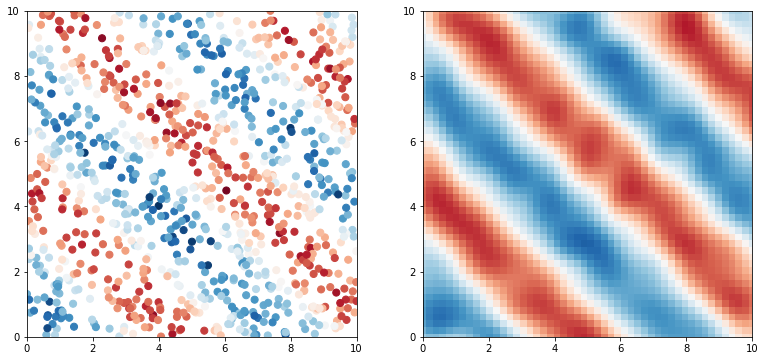

In [387]:
f, axes = plt.subplots(1, 2, figsize=(13, 6))

style = dict(cmap="RdBu", vmin=-1.5, vmax=1.5)
axes[0].scatter(x[:, 0], x[:, 1], c=y, s=50, **style)
axes[1].scatter(
    test_pts[:, 0], test_pts[:, 1], c=mu, s=50, marker="s", edgecolor="none", **style
)


for ax in axes:
    ax.set_xlim(0, np.sqrt(n_samples / 10))
    ax.set_ylim(0, np.sqrt(n_samples / 10))

In [388]:
print("Initial ln-likelihood: {0:.2f}".format(gp.log_likelihood(y)))

Initial ln-likelihood: -90.79


In [389]:
result = minimize(neg_ln_like, gp.get_parameter_vector(), jac=grad_neg_ln_like)
print(result)

gp.set_parameter_vector(result.x)
print("\nFinal ln-likelihood: {0:.2f}".format(gp.log_likelihood(y)))

      fun: -22.65977231802276
 hess_inv: array([[ 2.14345094e-03, -7.83241794e-05,  3.05084688e-05],
       [-7.83241794e-05,  1.78965538e-01,  5.25559211e-02],
       [ 3.05084688e-05,  5.25559211e-02,  1.91594354e-02]])
      jac: array([-1.49582204e-07, -7.91290660e-08,  5.08045872e-09])
  message: 'Optimization terminated successfully.'
     nfev: 14
      nit: 11
     njev: 14
   status: 0
  success: True
        x: array([-3.15705015, -0.04616422,  1.2045276 ])

Final ln-likelihood: 22.66


In [390]:
mu, cov = gp.predict(y, test_pts)

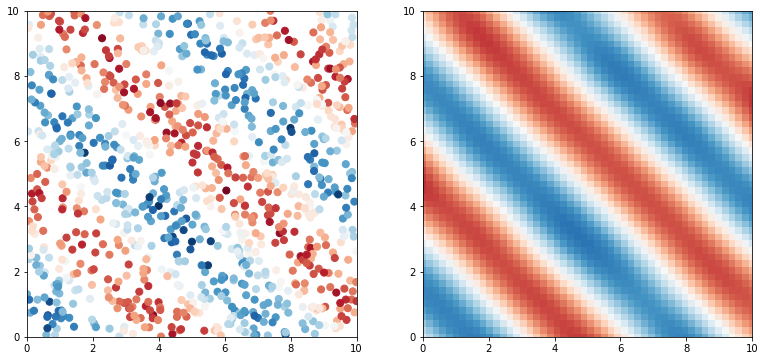

In [391]:
f, axes = plt.subplots(1, 2, figsize=(13, 6))

style = dict(cmap="RdBu", vmin=-1.5, vmax=1.5)
axes[0].scatter(x[:, 0], x[:, 1], c=y, s=50, **style)
axes[1].scatter(
    test_pts[:, 0], test_pts[:, 1], c=mu, s=50, marker="s", edgecolor="none", **style
)


for ax in axes:
    ax.set_xlim(0, np.sqrt(n_samples / 10))
    ax.set_ylim(0, np.sqrt(n_samples / 10))

##  -- Decide which kernel to use for argo data



In [ ]:
# https://www.inf.ed.ac.uk/teaching/courses/mlpr/2016/notes/w7c_gaussian_process_kernels.pdf

# A Kernal is a covariance function or how related features are in space / covary with each other

# Choice linked to the distribution/ variability in region to be interpolated?

# Assume local stationarity following K&S 2018
# Kernels that are stationary
# W&S present an anisotropic exponential space-time covariance function  - this would then allow for 3d ?

# Is it nessecary to emulate kernel from Eq 3.2 of K&S 2018 ?

## Anticipate the need to scale up

### George provides an approximate solver

In [ ]:
# Testing this out
# Compare previous to approximate solver, solutions similar, does speed things up

In [38]:
n_samples = 1000
x, y = fake_2d_data(n_samples)

test_pts = (
    np.array(
        np.meshgrid(
            np.linspace(0, np.sqrt(n_samples / 10.0), num=75),
            np.linspace(0, np.sqrt(n_samples / 10.0), num=75),
        )
    )
    .reshape(2, -1)
    .T
)

#%time mu, cov = gp.predict(y, test_pts)

kernel = 0.5 * Matern32Kernel(0.5, ndim=2)

In [39]:
gp = george.GP(kernel, white_noise=np.log(0.19 ** 2), fit_white_noise=True)
%time gp.compute(x)

%time mu, cov = gp.predict(y, test_pts)

CPU times: user 39.7 ms, sys: 3.61 ms, total: 43.3 ms
Wall time: 28.9 ms
CPU times: user 3.63 s, sys: 145 ms, total: 3.77 s
Wall time: 1.24 s


In [40]:
# quicker on the compute part
gp_hodlr = george.GP(
    kernel,
    white_noise=np.log(0.19 ** 2),
    fit_white_noise=True,
    solver=george.HODLRSolver,
    seed=42,
)
%time gp_hodlr.compute(x)
print(gp_hodlr.log_likelihood(y))

%time mu, cov = gp.predict(y, test_pts)

CPU times: user 8.71 ms, sys: 1.17 ms, total: 9.89 ms
Wall time: 9.53 ms
-501.78775542089306
CPU times: user 3.41 s, sys: 195 ms, total: 3.6 s
Wall time: 1.32 s


### Moving Window  

In [ ]:
# how did they do this? Nearest neightbours, Quadtree?